In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import os

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import os
def clean_country_data(country_name, file_path, output_dir='data'):
    print(f"\n🧹 Cleaning data for {country_name}...")
    df = pd.read_csv(file_path)
    print(f"loaded {file_path}->{df.shape[0]} rows")
    df=df.drop_duplicates()
    
    
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    numeric_cols = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'WSgust', 'ModA', 'ModB']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col].fillna(df[col].median())
    
    cols_for_outliers = [c for c in numeric_cols if c in df.columns]
    z = np.abs(stats.zscore(df[cols_for_outliers], nan_policy='omit'))
    df = df[(z < 3).all(axis=1)]

    df = df.sort_values('Timestamp').reset_index(drop=True)
    os.makedirs(output_dir, exist_ok=True)
    cleaned_file = os.path.join(output_dir, f"{country_name.lower().replace(' ', '_')}_clean.csv")
    df.to_csv(cleaned_file, index=False)

    print(f"Cleaned file saved: {cleaned_file} ({df.shape[0]} rows)")
    return df

data_path1 = os.path.join("..", "data", "benin-malanville.csv")
data_path2 = os.path.join("..", "data", "sierraleone-bumbuna.csv")
data_path3 = os.path.join("..", "data", "togo-dapaong_qc.csv")

countries ={
    'benin' : data_path1,
    'sierra leone':data_path2,
    'togo':data_path3
}

cleaned_df = {}
for country, path in countries.items():
    cleaned_df[country] = clean_country_data(country, path)

print("\nAll countries cleaned successfully!")



🧹 Cleaning data for benin...
loaded ..\data\benin-malanville.csv->525600 rows
Cleaned file saved: data\benin_clean.csv (517860 rows)

🧹 Cleaning data for sierra leone...
loaded ..\data\sierraleone-bumbuna.csv->525600 rows
Cleaned file saved: data\sierra_leone_clean.csv (504632 rows)

🧹 Cleaning data for togo...
loaded ..\data\togo-dapaong_qc.csv->525600 rows
Cleaned file saved: data\togo_clean.csv (516349 rows)

All countries cleaned successfully!


Metric Comparison

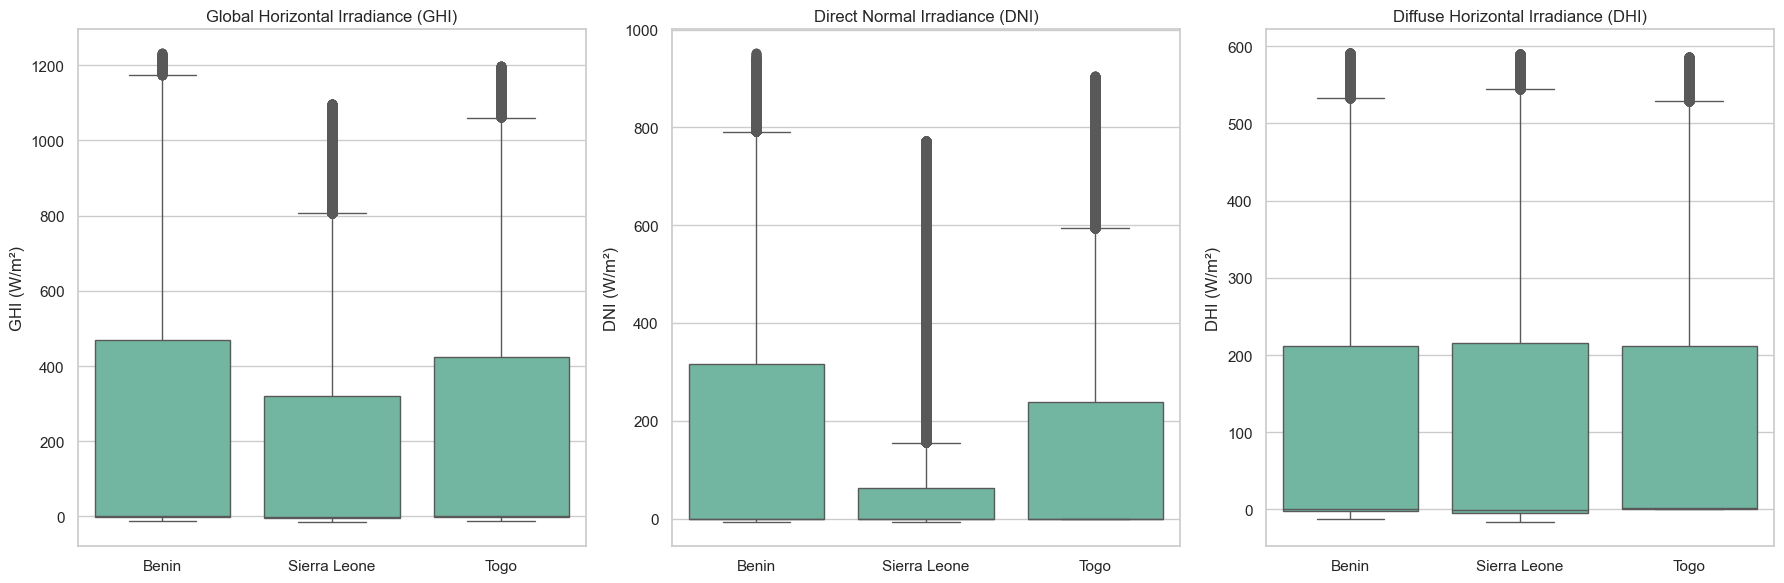

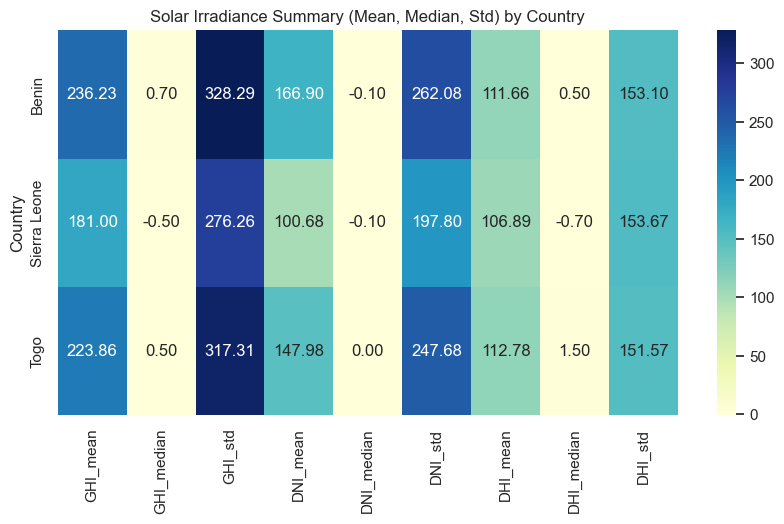

In [10]:
#1.Boxplots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
benin = pd.read_csv('data/benin_clean.csv')
sierra = pd.read_csv('data/sierra_leone_clean.csv')
togo = pd.read_csv('data/togo_clean.csv')


benin['Country'] = 'Benin'
sierra['Country'] = 'Sierra Leone'
togo['Country'] = 'Togo'


df_all = pd.concat([benin, sierra, togo], ignore_index=True)


sns.set(style="whitegrid", palette="Set2")


fig, axes = plt.subplots(1, 3, figsize=(18, 6))


sns.boxplot(x='Country', y='GHI', data=df_all, ax=axes[0])
axes[0].set_title('Global Horizontal Irradiance (GHI)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('GHI (W/m²)')


sns.boxplot(x='Country', y='DNI', data=df_all, ax=axes[1])
axes[1].set_title('Direct Normal Irradiance (DNI)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('DNI (W/m²)')


sns.boxplot(x='Country', y='DHI', data=df_all, ax=axes[2])
axes[2].set_title('Diffuse Horizontal Irradiance (DHI)', fontsize=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('DHI (W/m²)')


plt.tight_layout()
plt.show()

#2.summary Table
summary = (
    df_all.groupby('Country')[['GHI', 'DNI', 'DHI']]
    .agg(['mean', 'median', 'std'])
    .round(2)
)

summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]


plt.figure(figsize=(10, 5))
sns.heatmap(summary, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Solar Irradiance Summary (Mean, Median, Std) by Country")
plt.ylabel("Country")
plt.show()

Solar Irradiance Comparison (GHI) Across Countries

ANOVA Test  : F-statistic = 4500.974, p-value = 0.00000
Kruskal-Wallis Test : H-statistic = 7595.558, p-value = 0.00000

Result: Significant difference in GHI between at least two countries.


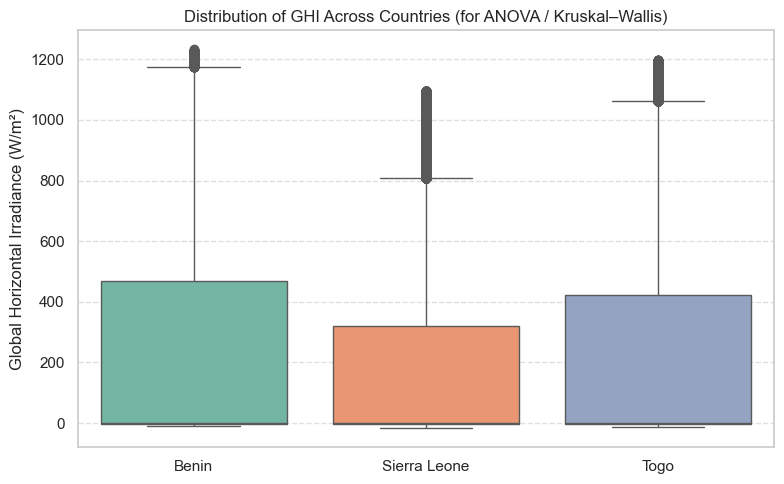

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats



benin = df_all[df_all['Country'].str.lower() == 'benin']['GHI'].dropna()
sierra = df_all[df_all['Country'].str.lower() == 'sierra leone']['GHI'].dropna()
togo = df_all[df_all['Country'].str.lower() == 'togo']['GHI'].dropna()



one, two = stats.f_oneway(benin, sierra, togo)

three, four = stats.kruskal(benin, sierra, togo)

print("Solar Irradiance Comparison (GHI) Across Countries\n")
print(f"ANOVA Test  : F-statistic = {one:.3f}, p-value = {two:.5f}")
print(f"Kruskal-Wallis Test : H-statistic = {three:.3f}, p-value = {four:.5f}")


if two < 0.05 or four < 0.05:
    print("\nResult: Significant difference in GHI between at least two countries.")
else:
    print("\nResult: No statistically significant difference in GHI between countries.")

# --- STEP 5: Visualization ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all, x='Country', y='GHI', hue='Country', palette='Set2', legend=False)
plt.title("Distribution of GHI Across Countries (for ANOVA / Kruskal–Wallis)")
plt.ylabel("Global Horizontal Irradiance (W/m²)")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Both the ANOVA (F = 4500.97, p < 0.001) and Kruskal–Wallis (H = 7595.56, p < 0.001) tests show highly significant differences in GHI values across Benin, Sierra Leone, and Togo.

Since the p-values are effectively 0.00000 (< 0.05), we can confidently conclude that at least one country has a statistically different level of solar irradiance compared to the others.

This suggests substantial variation in solar potential between the three sites.

p<0.05 is significant difference

Solar Irradiance Comaprision

* Benin shows the highest median GHI: 
    1.indicating stronger solar irradiance potential overall. 
*Togo exhibits moderate GHI levels:
    1.relatively stable values across observations.
*Sierra Leone records thelowest GHI and highest variability:
    1.suggesting more cloud cover or inconsistent sunlight conditions. 
Both ANOVA and Kruskal–Wallis tests (p < 0.001) confirm that GHI differences between the three countries are statistically significant.

Average Bar chart GHI by Country

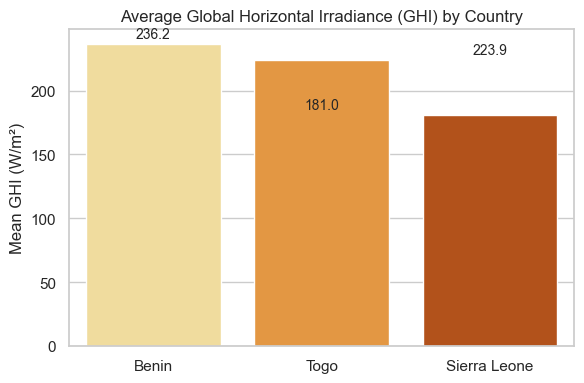

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


ghi = (
    df_all.groupby('Country')['GHI']
    .mean()
    .reset_index()
    .sort_values('GHI', ascending=False)
)

# Plot small bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=ghi, x='Country', y='GHI', hue='Country', palette='YlOrBr')

# Add value labels
for index, row in ghi.iterrows():
    plt.text(index, row['GHI'] + 5, f"{row['GHI']:.1f}", ha='center', fontsize=10)

plt.title("Average Global Horizontal Irradiance (GHI) by Country")
plt.ylabel("Mean GHI (W/m²)")
plt.xlabel("")
plt.tight_layout()
plt.show()
